# Dot Plot of Neuromodulator Receptor Expression in Prelimbic, Infralimbic & Dorsal ACC

This notebook examines 10x single-cell RNA sequencing data from the Allen Brain Cell
(ABC) Atlas to visualize the expression of serotonin, norepinephrine, and dopamine
receptor genes across cell types in the **medial prefrontal cortex (mPFC)** of the
mouse brain, specifically the prelimbic (PL), infralimbic (IL), and dorsal anterior
cingulate cortex (dACC) areas.

The output is a **dot plot** showing mean expression (color) and fraction of expressing
cells (dot size) for each gene by cell type (subclass level).

### Cell Type Selection
These areas span two ABC Atlas dissection regions:
- **PL-ILA-ORB**: Prelimbic, infralimbic, and orbital areas
- **ACA**: Anterior cingulate area

We include:
- **Cortical excitatory neurons**: Layer-defined subclasses (L2/3 IT through L6b)
- **Major cortical interneuron classes**: Pvalb, Sst, Vip, Lamp5, Sncg and related
  subclasses

All cell types are standard isocortical types shared across cortical areas. They are
not exclusive to PL/IL/ACA but are filtered to cells dissected from these regions.

### Prerequisites
- Internet connection (for downloading data from AWS S3)
- Run the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) first
- Packages: `abc_atlas_access`, `anndata`, `scanpy`, `pandas`, `numpy`, `matplotlib`

In [1]:
import pandas as pd
import numpy as np
import re
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

Set the download directory and create the cache object. Data will be downloaded
from AWS S3 on first access and cached locally for subsequent runs.

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)

print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata and Taxonomy

Load the cell metadata for all 4 million cells in the WMB-10X dataset,
the gene metadata, and the cluster taxonomy annotations.

In [3]:
# Load cell metadata
cell = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print(f"Total cells in WMB-10X: {len(cell):,}")

Total cells in WMB-10X: 4,042,976


In [4]:
# Load gene metadata
gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)
print(f"Total genes: {len(gene):,}")

Total genes: 32,285


In [5]:
# Load cluster taxonomy pivot table (maps cluster_alias -> all annotation levels)
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)

# Join taxonomy annotations onto cell metadata
cell_extended = cell.join(cluster_details, on='cluster_alias')
print(f"Taxonomy levels: {list(cluster_details.columns)}")
print(f"Cells with annotations: {len(cell_extended):,}")

Taxonomy levels: ['neurotransmitter', 'class', 'subclass', 'supertype', 'cluster']
Cells with annotations: 4,042,976


## 3. Identify PL/IL/dACC Cells

The prelimbic (PL), infralimbic (IL/ILA), and dorsal anterior cingulate (ACA)
areas span two ABC Atlas dissection regions:
- **PL-ILA-ORB**: Prelimbic + infralimbic + orbital cortex
- **ACA**: Anterior cingulate area

We combine cells from both regions, then select cortical excitatory neurons
(layer-defined types) and major GABAergic interneuron classes.

In [6]:
# Filter to PL-ILA-ORB and ACA dissection regions
mpfc_rois = ['PL-ILA-ORB', 'ACA']
mpfc_cells = cell_extended[cell_extended['region_of_interest_acronym'].isin(mpfc_rois)]
print(f"Cells in mPFC regions: {len(mpfc_cells):,}")
for roi, count in mpfc_cells.groupby('region_of_interest_acronym').size().items():
    print(f"  {roi}: {count:,}")

# Show subclass breakdown (top 25)
print(f"\nSubclasses in mPFC (top 25):")
subclass_counts = mpfc_cells.groupby('subclass', observed=True).size().sort_values(ascending=False)
for sc_name, count in subclass_counts.head(25).items():
    print(f"  {sc_name}: {count:,} cells")

Cells in mPFC regions: 208,916
  ACA: 102,794
  PL-ILA-ORB: 106,122

Subclasses in mPFC (top 25):
  030 L6 CT CTX Glut: 38,354 cells
  006 L4/5 IT CTX Glut: 23,357 cells
  004 L6 IT CTX Glut: 20,452 cells
  007 L2/3 IT CTX Glut: 18,401 cells
  005 L5 IT CTX Glut: 15,020 cells
  319 Astro-TE NN: 14,917 cells
  053 Sst Gaba: 9,267 cells
  032 L5 NP CTX Glut: 7,529 cells
  046 Vip Gaba: 7,209 cells
  334 Microglia NN: 6,823 cells
  327 Oligo NN: 6,190 cells
  022 L5 ET CTX Glut: 5,710 cells
  049 Lamp5 Gaba: 5,211 cells
  052 Pvalb Gaba: 4,852 cells
  326 OPC NN: 4,676 cells
  333 Endo NN: 4,489 cells
  029 L6b CTX Glut: 3,295 cells
  020 L2/3 IT RSP Glut: 2,666 cells
  047 Sncg Gaba: 2,452 cells
  331 Peri NN: 1,063 cells
  003 L5/6 IT TPE-ENT Glut: 792 cells
  002 IT EP-CLA Glut: 771 cells
  021 L4 RSP-ACA Glut: 675 cells
  332 SMC NN: 634 cells
  056 Sst Chodl Gaba: 418 cells


In [7]:
# --- Cortical excitatory neuron subclasses ---
excitatory_subclasses = [
    '007 L2/3 IT CTX Glut',
    '006 L4/5 IT CTX Glut',
    '005 L5 IT CTX Glut',
    '022 L5 ET CTX Glut',
    '032 L5 NP CTX Glut',
    '004 L6 IT CTX Glut',
    '030 L6 CT CTX Glut',
    '029 L6b CTX Glut',
    '021 L4 RSP-ACA Glut',
    '020 L2/3 IT RSP Glut',
]

# --- Major cortical interneuron subclasses ---
interneuron_subclasses = [
    '052 Pvalb Gaba',
    '051 Pvalb chandelier Gaba',
    '053 Sst Gaba',
    '056 Sst Chodl Gaba',
    '046 Vip Gaba',
    '049 Lamp5 Gaba',
    '050 Lamp5 Lhx6 Gaba',
    '047 Sncg Gaba',
]

# Verify subclasses exist in our region
mpfc_subclass_set = set(mpfc_cells['subclass'].unique())
excitatory_subclasses = [s for s in excitatory_subclasses if s in mpfc_subclass_set]
interneuron_subclasses = [s for s in interneuron_subclasses if s in mpfc_subclass_set]

selected_subclasses = sorted(set(excitatory_subclasses + interneuron_subclasses))

print(f"Cortical excitatory subclasses ({len(excitatory_subclasses)}):")
for sc_name in sorted(excitatory_subclasses):
    count = (mpfc_cells['subclass'] == sc_name).sum()
    print(f"  {sc_name}: {count:,} cells")

print(f"\nInterneuron subclasses ({len(interneuron_subclasses)}):")
for sc_name in sorted(interneuron_subclasses):
    count = (mpfc_cells['subclass'] == sc_name).sum()
    print(f"  {sc_name}: {count:,} cells")

Cortical excitatory subclasses (10):
  004 L6 IT CTX Glut: 20,452 cells
  005 L5 IT CTX Glut: 15,020 cells
  006 L4/5 IT CTX Glut: 23,357 cells
  007 L2/3 IT CTX Glut: 18,401 cells
  020 L2/3 IT RSP Glut: 2,666 cells
  021 L4 RSP-ACA Glut: 675 cells
  022 L5 ET CTX Glut: 5,710 cells
  029 L6b CTX Glut: 3,295 cells
  030 L6 CT CTX Glut: 38,354 cells
  032 L5 NP CTX Glut: 7,529 cells

Interneuron subclasses (8):
  046 Vip Gaba: 7,209 cells
  047 Sncg Gaba: 2,452 cells
  049 Lamp5 Gaba: 5,211 cells
  050 Lamp5 Lhx6 Gaba: 389 cells
  051 Pvalb chandelier Gaba: 282 cells


  052 Pvalb Gaba: 4,852 cells
  053 Sst Gaba: 9,267 cells
  056 Sst Chodl Gaba: 418 cells


In [8]:
# Filter to selected cell types
mpfc_selected = mpfc_cells[mpfc_cells['subclass'].isin(selected_subclasses)].copy()

print(f"Total mPFC cells selected: {len(mpfc_selected):,}")
print(f"  Excitatory: {mpfc_selected['subclass'].isin(excitatory_subclasses).sum():,}")
print(f"  Inhibitory: {mpfc_selected['subclass'].isin(interneuron_subclasses).sum():,}")

# Show subclass-level breakdown
print(f"\nAll selected subclasses ({len(selected_subclasses)}):")
for sc_name, count in mpfc_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    tag = "" if sc_name in excitatory_subclasses else " (IN)"
    print(f"  {sc_name}: {count:,} cells{tag}")

Total mPFC cells selected: 165,539
  Excitatory: 135,459
  Inhibitory: 30,080

All selected subclasses (18):
  030 L6 CT CTX Glut: 38,354 cells
  006 L4/5 IT CTX Glut: 23,357 cells
  004 L6 IT CTX Glut: 20,452 cells
  007 L2/3 IT CTX Glut: 18,401 cells
  005 L5 IT CTX Glut: 15,020 cells
  053 Sst Gaba: 9,267 cells (IN)
  032 L5 NP CTX Glut: 7,529 cells
  046 Vip Gaba: 7,209 cells (IN)
  022 L5 ET CTX Glut: 5,710 cells
  049 Lamp5 Gaba: 5,211 cells (IN)
  052 Pvalb Gaba: 4,852 cells (IN)
  029 L6b CTX Glut: 3,295 cells
  020 L2/3 IT RSP Glut: 2,666 cells
  047 Sncg Gaba: 2,452 cells (IN)
  021 L4 RSP-ACA Glut: 675 cells
  056 Sst Chodl Gaba: 418 cells (IN)
  050 Lamp5 Lhx6 Gaba: 389 cells (IN)
  051 Pvalb chandelier Gaba: 282 cells (IN)


## 4. Define Receptor Gene Lists

We define three families of neuromodulator receptor genes (mouse nomenclature):
- **Serotonin (5-HT) receptors** (`Htr*`)
- **Norepinephrine (adrenergic) receptors** (`Adra*`, `Adrb*`)
- **Dopamine receptors** (`Drd*`)

In [9]:
# Serotonin (5-HT) receptors
serotonin_receptors = [
    'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f',
    'Htr2a', 'Htr2b', 'Htr2c',
    'Htr3a', 'Htr3b',
    'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'
]

# Norepinephrine (adrenergic) receptors
norepinephrine_receptors = [
    'Adra1a', 'Adra1b', 'Adra1d',
    'Adra2a', 'Adra2b', 'Adra2c',
    'Adrb1', 'Adrb2', 'Adrb3'
]

# Dopamine receptors
dopamine_receptors = [
    'Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5'
]

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
print(f"Total receptor genes: {len(all_receptors)}")
print(f"  Serotonin: {len(serotonin_receptors)}")
print(f"  Norepinephrine: {len(norepinephrine_receptors)}")
print(f"  Dopamine: {len(dopamine_receptors)}")

Total receptor genes: 28
  Serotonin: 14
  Norepinephrine: 9
  Dopamine: 5


In [10]:
# Verify which genes are present in the dataset
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
found_symbols = set(available_genes['gene_symbol'])
missing = [g for g in all_receptors if g not in found_symbols]

print(f"Found {len(found_symbols)}/{len(all_receptors)} receptor genes in the dataset")
if missing:
    print(f"Missing genes: {missing}")

# Update gene list to only include available genes
receptor_genes = [g for g in all_receptors if g in found_symbols]
print(f"\nUsing {len(receptor_genes)} genes for analysis")

Found 28/28 receptor genes in the dataset

Using 28 genes for analysis


## 5. Load Expression Data

mPFC cells are spread across 6 large Isocortex expression matrix files
(both 10Xv2 and 10Xv3 chemistries, ~8-12 GB each). Since they don't all
fit on disk simultaneously, we use a helper script (`extract_mpfc_expression.py`)
that downloads each file, extracts just the 28 receptor genes for our selected
cells, saves the result to CSV, then deletes the large h5ad file before
downloading the next one.

If the pre-extracted CSV exists, we load it directly. Otherwise, run the
extraction script first:
```bash
python extract_mpfc_expression.py
```

In [11]:
import os
import subprocess

csv_path = 'mpfc_receptor_expression.csv'

if not os.path.exists(csv_path):
    print("Pre-extracted CSV not found. Running extraction script...")
    print("This will download ~55 GB of h5ad files one at a time (takes ~30 min)")
    result = subprocess.run(['python', 'extract_mpfc_expression.py'],
                            capture_output=True, text=True)
    print(result.stdout)
    if result.returncode != 0:
        print("STDERR:", result.stderr)
        raise RuntimeError("Extraction script failed")

expression_data = pd.read_csv(csv_path, index_col=0)
print(f"Loaded expression data: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

Loaded expression data: 165,539 cells x 28 genes


## 6. Build AnnData Object for Dot Plot

Combine the expression data with cell type annotations into a single
AnnData object for visualization with scanpy.

In [12]:
# Ensure expression columns are in the desired gene order
expression_data = expression_data[receptor_genes]

# Create AnnData object
adata_mpfc = anndata.AnnData(
    X=expression_data.values,
    obs=mpfc_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Create shorter display labels (strip leading number prefix)
adata_mpfc.obs['subclass_short'] = adata_mpfc.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_mpfc.obs['supertype_short'] = adata_mpfc.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)

adata_mpfc.obs['subclass'] = pd.Categorical(adata_mpfc.obs['subclass'])
adata_mpfc.obs['supertype'] = pd.Categorical(adata_mpfc.obs['supertype'])
adata_mpfc.obs['subclass_short'] = pd.Categorical(adata_mpfc.obs['subclass_short'])
adata_mpfc.obs['supertype_short'] = pd.Categorical(adata_mpfc.obs['supertype_short'])

n_subclasses = adata_mpfc.obs['subclass'].cat.categories.size
n_supertypes = adata_mpfc.obs['supertype'].cat.categories.size
print(adata_mpfc)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes in mPFC data")

AnnData object with n_obs × n_vars = 165539 × 28
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'subclass_short', 'supertype_short'

18 subclasses, 101 supertypes in mPFC data


## 7. Dot Plot: Receptor Expression by mPFC Cell Type (Subclass)

The dot plot shows:
- **Dot size**: Fraction of cells in each group expressing the gene (expression > 0)
- **Dot color**: Mean expression level (standard-scaled per gene)

Genes are grouped by receptor family (serotonin, norepinephrine, dopamine).
Cell types are grouped at the **subclass** level, combining cortical excitatory
neurons with major interneuron classes.

In [13]:
# Define gene groups for the dot plot
receptor_groups = {}

sero_available = [g for g in serotonin_receptors if g in receptor_genes]
ne_available = [g for g in norepinephrine_receptors if g in receptor_genes]
da_available = [g for g in dopamine_receptors if g in receptor_genes]

if sero_available:
    receptor_groups['Serotonin (5-HT)'] = sero_available
if ne_available:
    receptor_groups['Norepinephrine (NE)'] = ne_available
if da_available:
    receptor_groups['Dopamine (DA)'] = da_available

print("Gene groups for dot plot:")
for group, genes in receptor_groups.items():
    print(f"  {group}: {genes}")

Gene groups for dot plot:
  Serotonin (5-HT): ['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7']
  Norepinephrine (NE): ['Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3']
  Dopamine (DA): ['Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']


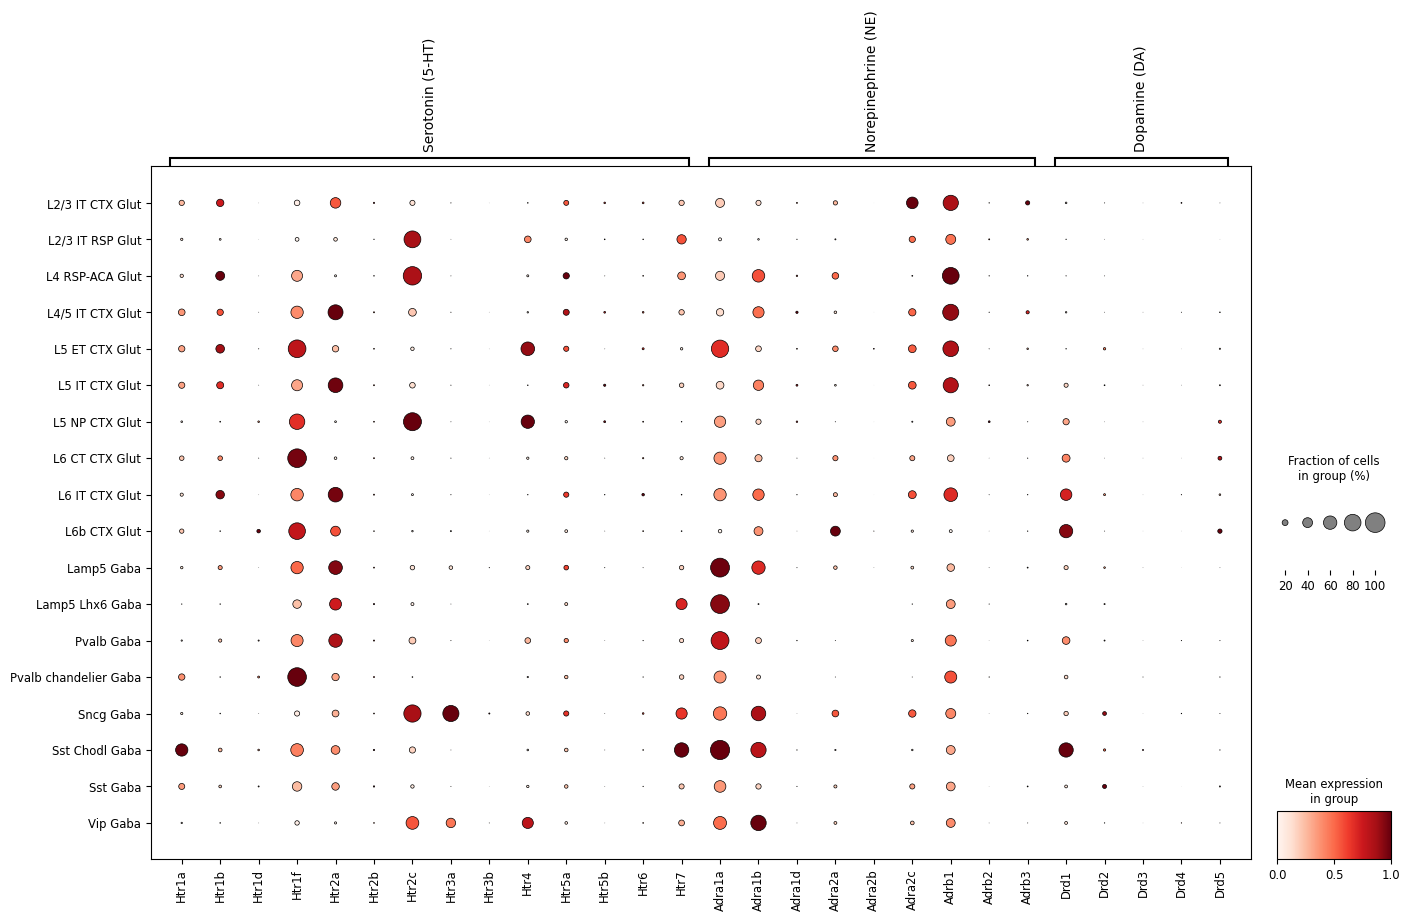

Saved: dotplot_mPFC_receptors_by_subclass.png


In [14]:
# Create the dot plot grouped by subclass
dp = sc.pl.dotplot(
    adata_mpfc,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_mPFC_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_mPFC_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

For a finer-grained view, we plot at the supertype level (one level below subclass).
We filter to supertypes with at least 100 cells for readability.

Supertypes with >= 100 cells: 81


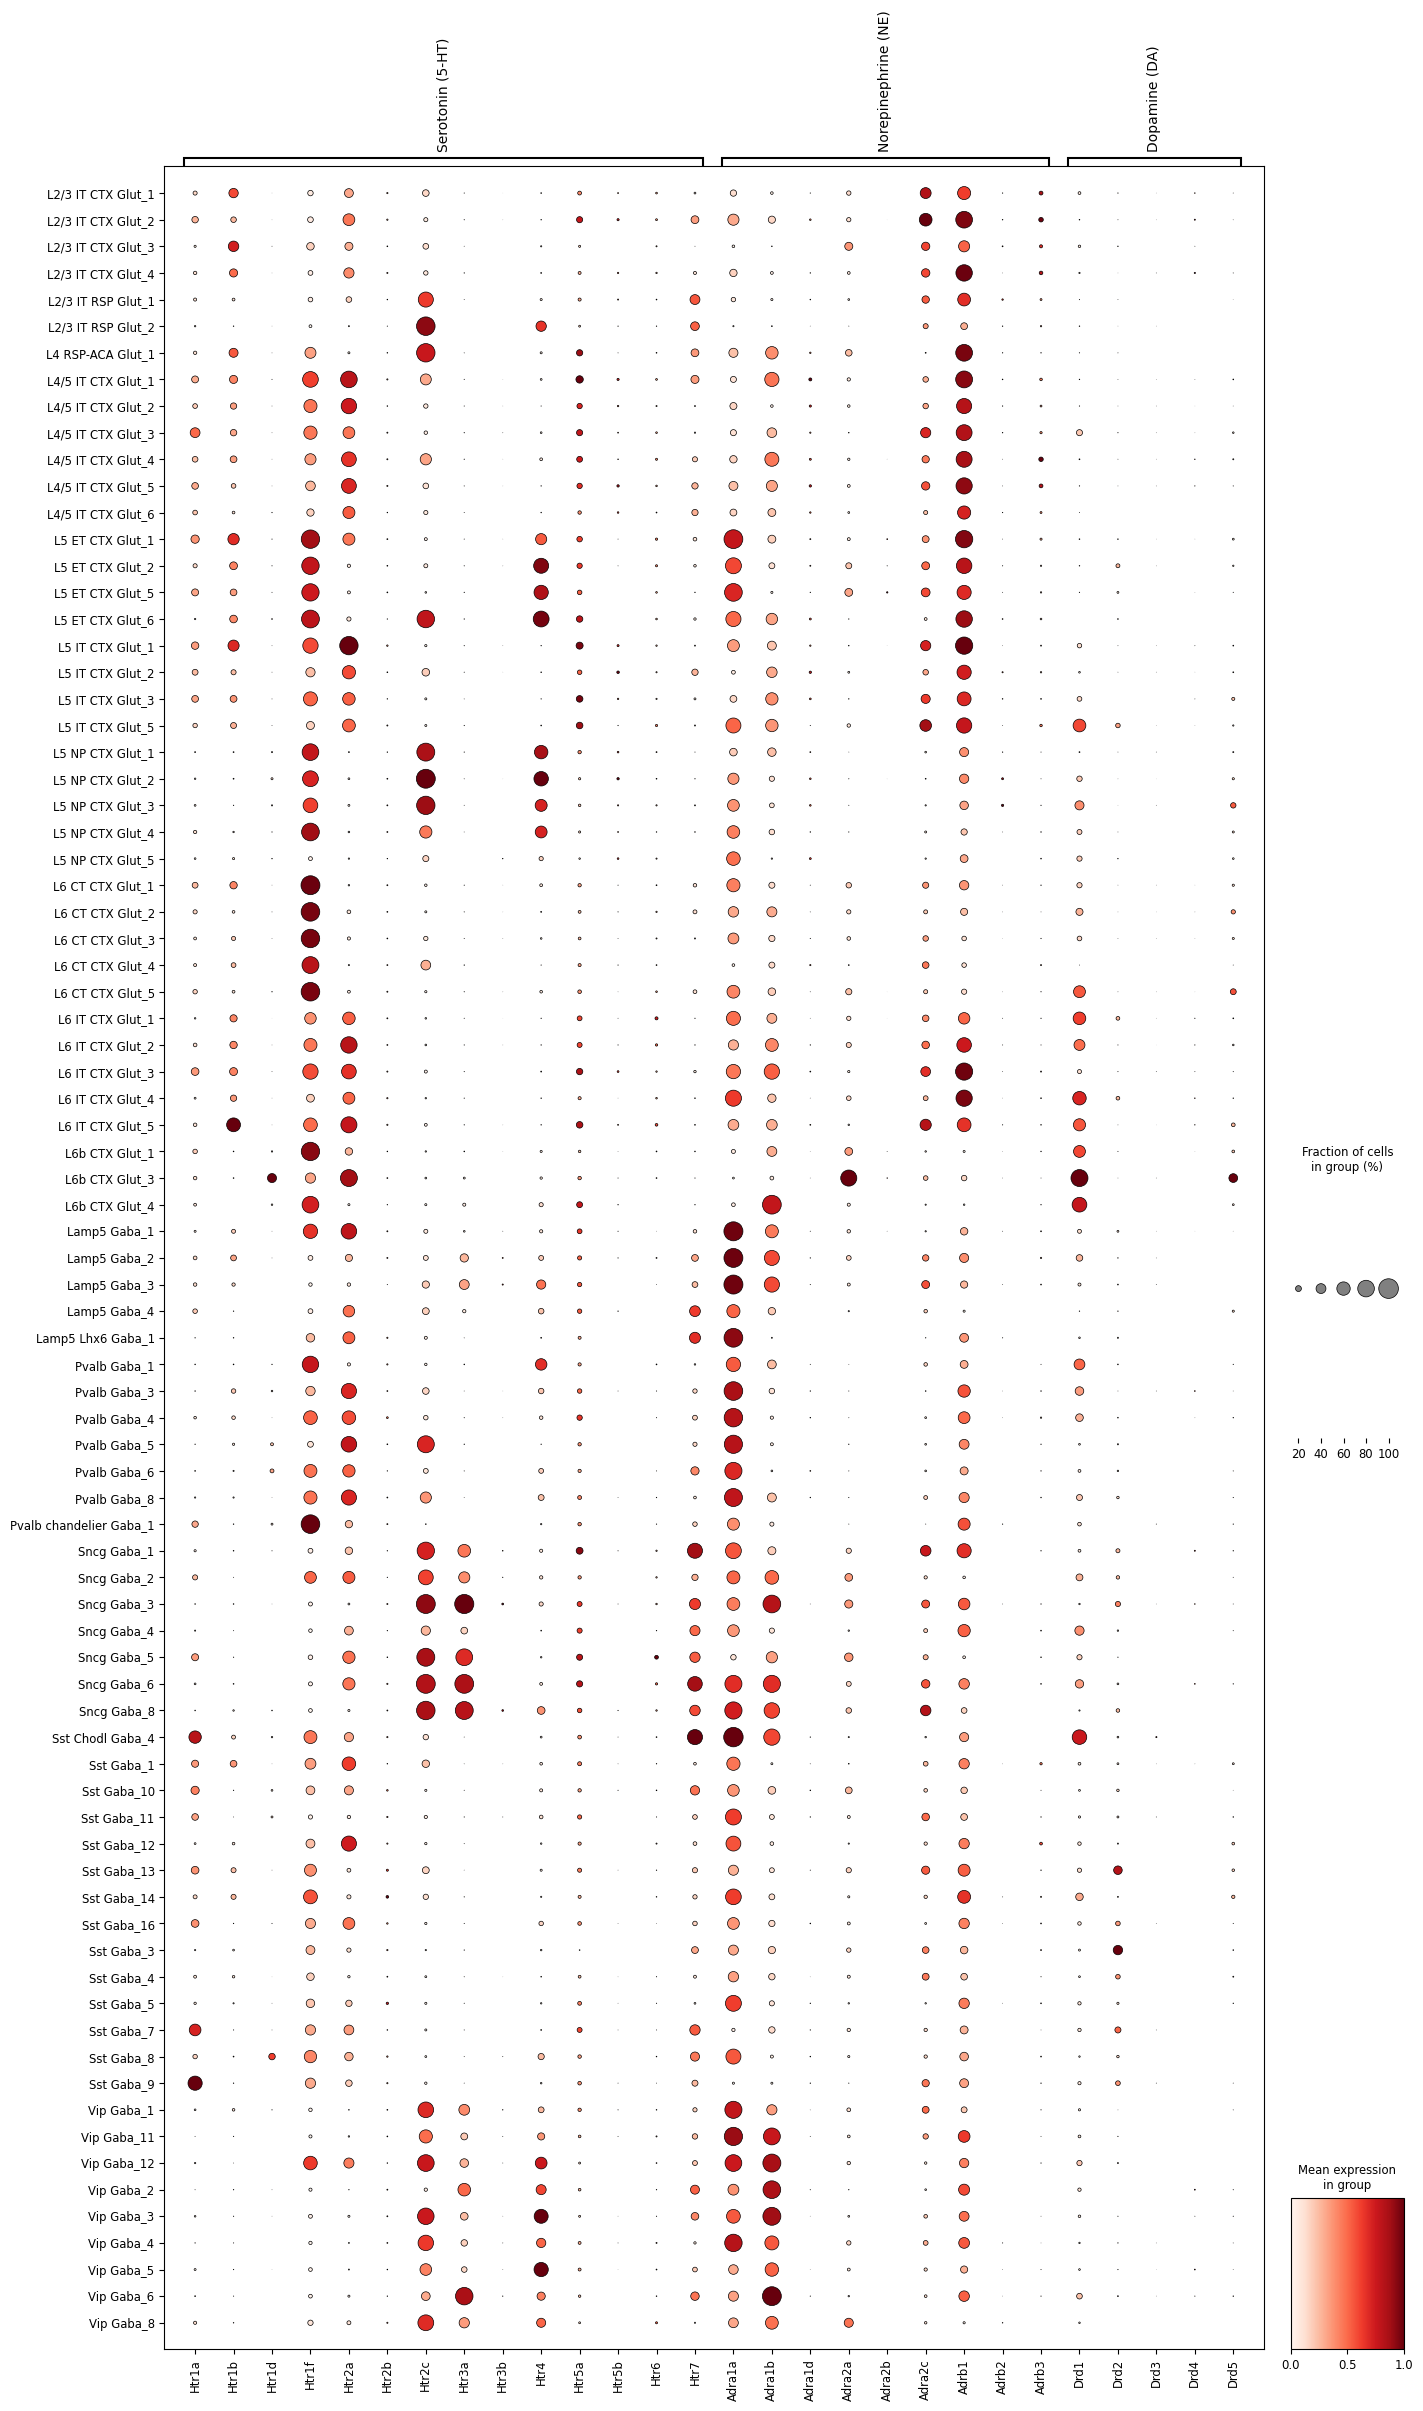

Saved: dotplot_mPFC_receptors_by_supertype.png


In [15]:
# Filter to supertypes with sufficient cells
min_cells = 100
supertype_counts = adata_mpfc.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_supertype = adata_mpfc[adata_mpfc.obs['supertype'].isin(valid_supertypes)].copy()
adata_supertype.obs['supertype_short'] = pd.Categorical(adata_supertype.obs['supertype_short'])

n_supertypes_plot = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_supertypes_plot}")

dp2 = sc.pl.dotplot(
    adata_supertype,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(8, n_supertypes_plot * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_mPFC_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_mPFC_receptors_by_supertype.png")

## 9. Summary Statistics

Mean expression and fraction of expressing cells for each receptor gene by mPFC subclass.

In [16]:
# Compute mean expression and fraction expressing per subclass
expr_df = pd.DataFrame(
    adata_mpfc.X,
    index=adata_mpfc.obs.index,
    columns=adata_mpfc.var.index
)
expr_df['subclass'] = adata_mpfc.obs['subclass'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 80)
print("Mean Expression (log2) by Subclass")
print("=" * 80)
display(mean_expr.round(2))

print("\n" + "=" * 80)
print("Fraction of Expressing Cells by Subclass")
print("=" * 80)
display(frac_expr.round(3))

Mean Expression (log2) by Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
004 L6 IT CTX Glut,0.48,1.93,0.00,3.63,4.55,0.11,0.26,0.03,0.00,0.05,...,0.00,1.66,3.85,0.02,0.04,2.95,0.27,0.00,0.03,0.20
005 L5 IT CTX Glut,1.17,1.41,0.01,2.94,4.61,0.10,1.16,0.03,0.00,0.06,...,0.00,1.59,4.55,0.08,0.16,0.70,0.09,0.00,0.01,0.10
006 L4/5 IT CTX Glut,1.28,1.19,0.01,3.52,4.68,0.10,1.77,0.03,0.00,0.17,...,0.00,1.47,4.96,0.03,0.47,0.18,0.01,0.01,0.02,0.07
007 L2/3 IT CTX Glut,0.93,1.56,0.00,1.01,2.68,0.13,1.01,0.03,0.00,0.07,...,0.00,2.87,4.64,0.04,0.66,0.20,0.02,0.00,0.09,0.01
020 L2/3 IT RSP Glut,0.38,0.26,0.00,0.72,0.70,0.05,7.05,0.01,0.00,1.80,...,0.00,1.43,2.79,0.13,0.24,0.05,0.01,0.00,0.00,0.00
021 L4 RSP-ACA Glut,0.53,2.06,0.01,2.92,0.28,0.06,6.95,0.02,0.00,0.27,...,0.00,0.10,5.39,0.04,0.04,0.03,0.01,0.00,0.00,0.00
022 L5 ET CTX Glut,1.16,1.82,0.02,6.35,1.31,0.08,0.64,0.03,0.00,3.96,...,0.08,1.55,4.60,0.02,0.17,0.05,0.32,0.00,0.00,0.12
029 L6b CTX Glut,0.79,0.07,0.60,6.24,2.76,0.07,0.20,0.13,0.00,0.33,...,0.03,0.33,0.47,0.01,0.05,3.86,0.02,0.00,0.00,0.76
030 L6 CT CTX Glut,0.81,0.85,0.02,7.60,0.40,0.10,0.47,0.03,0.00,0.35,...,0.00,0.93,1.39,0.01,0.04,1.75,0.01,0.00,0.00,0.64



Fraction of Expressing Cells by Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
004 L6 IT CTX Glut,0.088,0.328,0.001,0.548,0.676,0.021,0.047,0.005,0.000,0.009,...,0.000,0.297,0.616,0.003,0.008,0.491,0.047,0.000,0.006,0.038
005 L5 IT CTX Glut,0.215,0.255,0.002,0.464,0.676,0.020,0.189,0.005,0.000,0.012,...,0.000,0.288,0.709,0.015,0.031,0.125,0.017,0.001,0.001,0.020
006 L4/5 IT CTX Glut,0.237,0.221,0.002,0.539,0.698,0.021,0.289,0.005,0.001,0.031,...,0.000,0.267,0.767,0.006,0.089,0.032,0.002,0.001,0.004,0.013
007 L2/3 IT CTX Glut,0.175,0.271,0.001,0.187,0.436,0.027,0.168,0.005,0.000,0.013,...,0.000,0.498,0.714,0.008,0.128,0.037,0.004,0.001,0.017,0.002
020 L2/3 IT RSP Glut,0.058,0.042,0.000,0.112,0.107,0.008,0.814,0.002,0.000,0.237,...,0.000,0.219,0.405,0.020,0.038,0.008,0.002,0.000,0.000,0.000
021 L4 RSP-ACA Glut,0.095,0.354,0.001,0.462,0.049,0.012,0.917,0.003,0.000,0.049,...,0.000,0.018,0.809,0.007,0.009,0.006,0.003,0.000,0.000,0.000
022 L5 ET CTX Glut,0.220,0.335,0.005,0.871,0.225,0.017,0.100,0.005,0.001,0.614,...,0.015,0.290,0.742,0.004,0.036,0.010,0.060,0.001,0.000,0.026
029 L6b CTX Glut,0.133,0.013,0.103,0.802,0.398,0.013,0.033,0.023,0.000,0.055,...,0.005,0.058,0.080,0.001,0.008,0.593,0.003,0.000,0.000,0.132
030 L6 CT CTX Glut,0.142,0.146,0.004,0.935,0.068,0.020,0.077,0.005,0.001,0.058,...,0.000,0.165,0.240,0.001,0.007,0.297,0.001,0.001,0.000,0.114


## 10. Including Glia: Neurons + Microglia + Astrocytes

A third dot plot adds **microglia** and **astrocytes** (Astro-TE) from the mPFC
dissection regions alongside the neuronal subclasses, showing neuromodulator receptor
expression across all major cell classes.

Glia expression is pre-extracted by `extract_mpfc_glia_expression.py` using the
same download-extract-delete pipeline as the neuronal data.

In [ ]:
# Load glia expression data
glia_csv_path = 'mpfc_glia_receptor_expression.csv'

if not os.path.exists(glia_csv_path):
    print("Pre-extracted glia CSV not found. Running extraction script...")
    result = subprocess.run(['python', 'extract_mpfc_glia_expression.py'],
                            capture_output=True, text=True)
    print(result.stdout)
    if result.returncode != 0:
        print("STDERR:", result.stderr)
        raise RuntimeError("Glia extraction script failed")

glia_expression = pd.read_csv(glia_csv_path, index_col=0)[receptor_genes]
print(f"Loaded glia expression: {glia_expression.shape[0]:,} cells x {glia_expression.shape[1]} genes")

# Get glia cell metadata
glia_subclasses = ['319 Astro-TE NN', '334 Microglia NN']
glia_cells = mpfc_cells[mpfc_cells['subclass'].isin(glia_subclasses)].copy()
for sc_name, count in glia_cells.groupby('subclass', observed=True).size().items():
    print(f"  {sc_name}: {count:,} cells")

# Combine neuronal + glia
combined_expression = pd.concat([expression_data, glia_expression])
combined_cells = pd.concat([mpfc_selected, glia_cells])

# Save combined metadata for downstream analysis
meta_csv = 'mpfc_10x_metadata.csv'
combined_cells.loc[combined_expression.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter', 'region_of_interest_acronym']
].to_csv(meta_csv)
print(f"Saved metadata to {meta_csv}")

# Build combined AnnData
adata_combined = anndata.AnnData(
    X=combined_expression.values,
    obs=combined_cells.loc[combined_expression.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)
adata_combined.obs['subclass_short'] = adata_combined.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_combined.obs['subclass_short'] = pd.Categorical(adata_combined.obs['subclass_short'])

n_combined = adata_combined.obs['subclass_short'].cat.categories.size
print(f"\nCombined: {len(adata_combined):,} cells, {n_combined} subclasses (neurons + glia)")

# Generate dot plot
dp3 = sc.pl.dotplot(
    adata_combined,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_combined * 0.5)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_mPFC_receptors_with_glia.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_mPFC_receptors_with_glia.png")